In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
sns.set(color_codes=True)

In [2]:
# Auxiliary functions

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))


def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [3]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


In [4]:
default_clients = df.loc[df.default == 1]
non_default_clients = df.loc[df.default == 0]

print(f'Number of clients with default: {len(default_clients)}')
print(f'Number of clients without default: {len(non_default_clients)}')
print(f'Default rate: {len(default_clients) / len(df)}')

Number of clients with default: 6636
Number of clients without default: 23364
Default rate: 0.2212


**Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?**

C:\Users\Peter\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


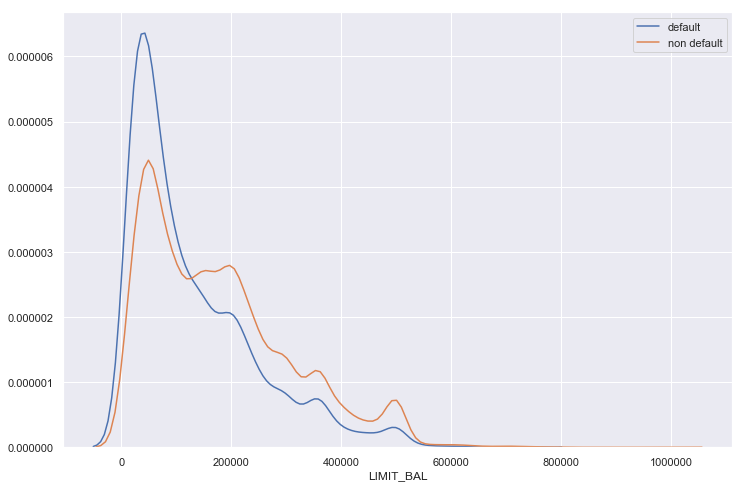

In [5]:
plt.subplots(figsize=(12, 8))
sns.distplot(default_clients.LIMIT_BAL, hist=False, label='default')
sns.distplot(non_default_clients.LIMIT_BAL, hist=False, label='non default')
plt.legend()

1. Построим доверительные интервалы для медианных значений кредитного лимита в двух группах, используя bootstrap

In [6]:
limit_bal_default_medians = np.median(get_bootstrap_samples(default_clients.LIMIT_BAL.values, 1000), axis=1)
limit_bal_non_default_medians = np.median(get_bootstrap_samples(non_default_clients.LIMIT_BAL.values, 1000), axis=1)

print("95% confidence interval for the LIMIT_BAL median of default customers:", 
      stat_intervals(limit_bal_default_medians, 0.05))
print("95% confidence interval for the LIMIT_BAL median of non-default customers:",  
      stat_intervals(limit_bal_non_default_medians, 0.05))

95% confidence interval for the LIMIT_BAL median of default customers: [80000. 90000.]
95% confidence interval for the LIMIT_BAL median of non-default customers: [150000. 150000.]


Доверительные интервалы не пересекаются. Видно, что клиенты с более высоким кредитным лимитом реже сталкиваются с проблемами при оплате кредита.

Проверим гипотезу о равенстве распределений кредитных лимитов в двух группах пользователей с помощью непараметрического критерия Манна-Уитни:

|Гипотеза|Описание|
|--|------------------------|
|H0|распределения совпадают|
|H1|между распределениями есть сдвиг|

In [7]:
stats.mannwhitneyu(default_clients.LIMIT_BAL, non_default_clients.LIMIT_BAL, alternative='two-sided')

MannwhitneyuResult(statistic=59257217.5, pvalue=1.2255485818223303e-189)

Как видно, критерий Манна-Уитни уверенно отвергает нулевую гипотезу на уровне значимости 0.05.   
Высокое значение кредитного лимита может говорить о том, что клиент уже брал в прошлом кредит и успешно с ним расплачивался. Так что, учитывая большую разницу в медианах кредитного лимита в разных группах, этот результат можно считать практически значимым.

**Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)**

C:\Users\Peter\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


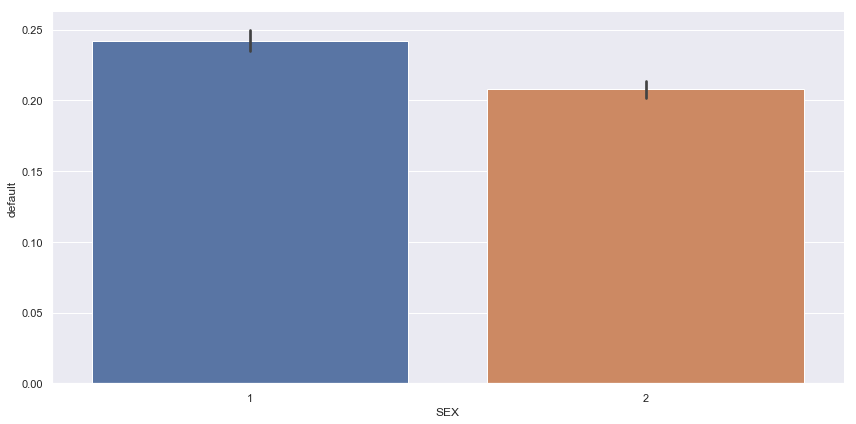

In [8]:
sns.catplot(x='SEX', y='default', kind='bar', data=df, height=6, aspect=2)

In [9]:
pd.crosstab(df.SEX, df.default, normalize=True)

default,0,1
SEX,,
1,0.3005,0.095767
2,0.4783,0.125433


Так как SEX принимает всего два значения, то можно считать этот признак бинарной переменной. Построим доверительные интервалы для доли клиентов мужского пола в группах вернувших и не вернувших кредит

In [10]:
proportion_confint((non_default_clients.SEX == 1).sum(), len(non_default_clients), method = 'wilson')

(0.3796273158089251, 0.392110265969876)

In [11]:
proportion_confint((default_clients.SEX == 1).sum(), len(default_clients), method = 'wilson')

(0.421062418034934, 0.4448982369717182)

Видно, что доля клиентов мужского пола в группе не вернувших кредит выше. Доверительные интервалы не пересекаются.

Проверим гипотезу о равенстве долей клиентов мужского пола в разных группах:

|Гипотеза|Описание|
|--|------------------------|
|H0|доля клиентов мужского пола в группах вернувших и не вернувших кредит совпадают|
|H1|доля клиентов мужского в группах вернувших и не вернувших кредит **не** совпадают|

In [12]:
proportions_diff_z_test(proportions_diff_z_stat_ind(non_default_clients.SEX == 1, default_clients.SEX == 1))

4.472866521609831e-12

Нулевая гипотеза уверенно отвергается на уровене значимости 0.05

Построим доверительный интервал для разности долей клиентов мужского пола в двух группах

In [13]:
proportions_diff_confint_ind(non_default_clients.SEX == 1, default_clients.SEX == 1)

(-0.060548077974896725, -0.03363493274962867)

Доверительный интервал разности целиком находится левее нуля. Это говорит о том, что в группе вернувших кредит доля клиентов с SEX == 1 ниже

**Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?**

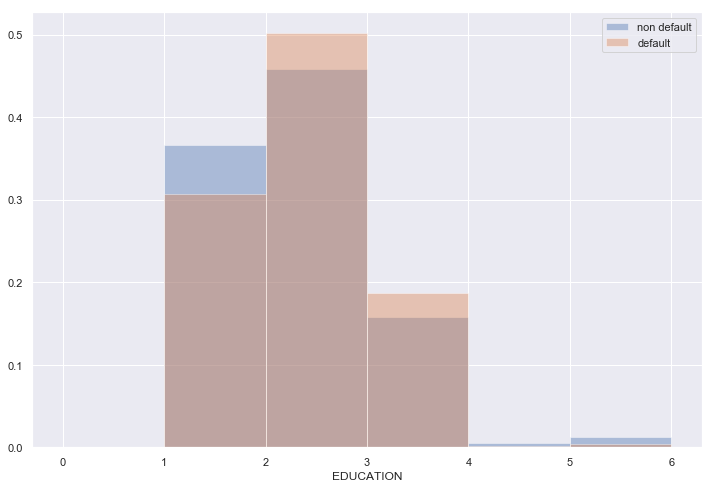

In [14]:
plt.subplots(figsize=(12, 8))
sns.distplot(non_default_clients.EDUCATION, kde=False, norm_hist=True, bins=6, label='non default')
sns.distplot(default_clients.EDUCATION, kde=False, norm_hist=True, bins=5, label='default')
plt.legend()

In [15]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

В том случае, если уровень образования не влияет на возврат кредита, доля клиентов с определенным уровнем образования, не вернувших кредит, должна быть примерно соответствовать средней доле невозвращенных кредитов. Тогда можно построить таблицу, где строки будут соответствовать уровню образования, а единственный столбец - разнице между количеством невозвращенных кредитов и ожидаемым количеством невозвращенных кредитов:

In [16]:
mean_default = df['default'].mean()
def agg(x):
    names = {
        'diff': x['default'].sum() - len(x) * mean_default
    }
    return pd.Series(names, index=['diff'])

df.groupby('EDUCATION').apply(agg)

,diff
EDUCATION,
0,-3.0968
1,-305.4020
2,226.5640
3,149.3596
4,-20.2076
5,-43.9360
6,-3.2812


Для того, чтобы было удобнее сравнивать, можно перейти от абсолютной разницы в количестве пользователей к разнице между фактической долей невозвратов и ожидаемой:

In [17]:
def agg(x):
    names = {
        'diff': x['default'].mean() - mean_default
    }
    return pd.Series(names, index=['diff'])

df.groupby('EDUCATION').apply(agg)

,diff
EDUCATION,
0,-0.221200
1,-0.028852
2,0.016149
3,0.030376
4,-0.164289
5,-0.156914
6,-0.064337


Можно заметить, что среди клиентов с научной степенью не встречается тех, кто не возвращает кредиты, а среди выпускников школ доля тех, кто не платит по кредиту выше среднего уровня.

**Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.**

C:\Users\Peter\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


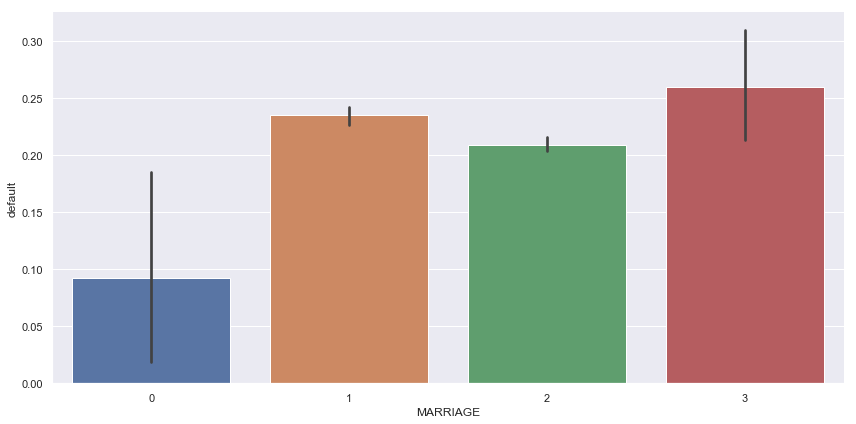

In [18]:
sns.catplot(x='MARRIAGE', y='default', kind='bar', data=df, height=6, aspect=2)

In [19]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

В качестве меры, показывающей связь между семейным статусом и индикатором дефолта, можно использовать коэффициент V Крамера. Вычислим его:

In [20]:
observed = pd.crosstab(df['MARRIAGE'], df['default'])
chi2, pvalue, *_ = stats.chi2_contingency(observed)
r = (chi2 / len(df) / (min(observed.shape) - 1)) ** .5
print(f'Коэффициент V Крамера: {r}. P-value: {pvalue}')

Коэффициент V Крамера: 0.034478203662766466. P-value: 8.825862457577375e-08


Видно, что между семейным положением и невыплатой кредита существует слабая связь. При этом гипотеза о равенстве нулю коэффициента корреляции отвергается на уровне значимости 0.05

**Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?**

C:\Users\Peter\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


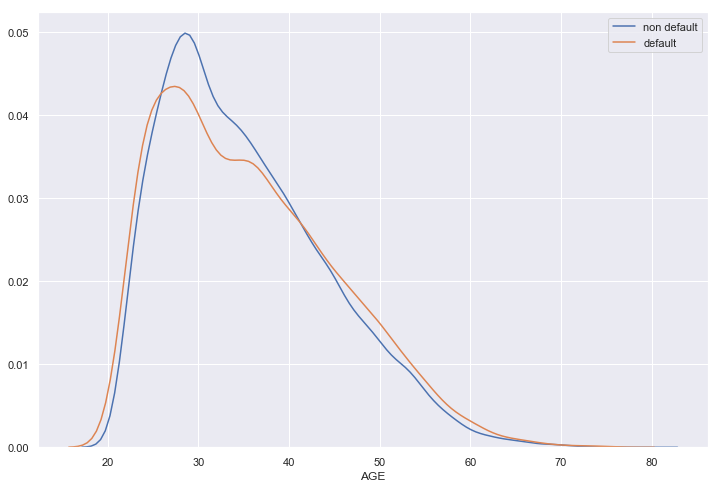

In [21]:
plt.subplots(figsize=(12, 8))
sns.distplot(non_default_clients.AGE, hist=False, label='non default')
sns.distplot(default_clients.AGE, hist=False, label='default')
plt.legend()

In [22]:
age_default_median = default_clients.AGE.median()
age_non_default_median = non_default_clients.AGE.median()
print(f'Default clients age median: {age_default_median}. Non-default clients age median: {age_non_default_median}')

Default clients age median: 34.0. Non-default clients age median: 34.0


In [23]:
age_default_medians = np.median(get_bootstrap_samples(default_clients.AGE.values, 1000), axis=1)
age_non_default_medians = np.median(get_bootstrap_samples(non_default_clients.AGE.values, 1000), axis=1)

print("95% confidence interval for the AGE of non-default customers:", stat_intervals(age_default_medians, 0.05))
print("95% confidence interval for the AGE of default customers:",  stat_intervals(age_non_default_medians, 0.05))

95% confidence interval for the AGE of non-default customers: [34. 35.]
95% confidence interval for the AGE of default customers: [34. 34.]


Проверим гипотезу о равенстве распределений возраста

|Гипотеза|Описание|
|--|------------------------|
|H0|распределения совпадают|
|H1|между распределениями есть сдвиг|

In [24]:
stats.mannwhitneyu(default_clients.AGE, non_default_clients.AGE, alternative='two-sided')

MannwhitneyuResult(statistic=78076624.5, pvalue=0.3725035434898616)

Видно, что медианы и их доверительные интервалы, построенные с помощью boostrap, совпадают. Также нельзя отвергнуть гипотезу о равенстве распределений возрастов в группах вернувших и не вернувших кредиты клиентов. Это может говорить о том, что данный признак не будет важным в модели скоринга и его можно удалить.